In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:



import pandas as pd
from sklearn.model_selection import train_test_split

raw_data_path = '/content/drive/MyDrive/news.csv'
destination_folder = '/content/drive/MyDrive'

train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 200

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x



In [3]:
df_raw = pd.read_csv(raw_data_path)

# column 준비
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + '.' + df_raw['text']
df_raw = df_raw.reindex(columns = ['label', 'title','text','titletext'])
# => ['label', 'title','text','titletext'] 순으로 데이터를 정렬하고 인덱스를 다시 매김

# 비어있는 텍스트가 존재하는 열 제거
df_raw.drop(df_raw[df_raw.text.str.len()<5].index, inplace = True)

# 텍스트를 자르고 titletext를 first_n_words까지 자름
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string)

# label을 기준으로 데이터를 나눈다
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# 훈련/테스트 분할
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# 훈련/검증 분할
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# 분할된 데이터를 연결한다. ( real + fake / 행 방향 )
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# 전처리된 데이터셋 저장
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
# Models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
device = torch.device("cuda")
# Training
import torch.optim as optim
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [5]:
label_field = Field(sequential = False, # 순서가 있는 데이터일경우 True / Label은 순서가 필요 없으므로 False
                    use_vocab = False, # 단어장(vocab) 객체 사용 여부 / 텍스트 데이터에만 True
                    batch_first = True, # 배치를 우선시
                    dtype = torch.float) 
text_field = Field(tokenize = 'spacy', 
                   lower = True, # 소문자 전환 여부 (엉어)
                   include_lengths = True, # 패딩된 미니 배치의 튜플과 각 샘플의 길이가 포함 된 목록을 반환 or 패딩된 미니 배치만 반환
                   batch_first = True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# Tabular Dataset
train, valid, test = TabularDataset.splits(path=destination_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)
# Iterators
# BucketIterator - batch learning을 함. 비슷한 길이를 가진 텍스트를 한 batch에 할당하여 패딩을 최소화하는 기능을 가짐.
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [6]:
class LSTM(nn.Module): # nn.Module 상속

    def __init__(self, dimension = 128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True) # 양방향
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*dimension, 1) #full connect

    def forward(self, text, text_len):
        text_emb = self.embedding(text)
        # pack_padded_sequence : padding된 문장을 padding 기준으로 sorting 하는 역할
        # 참고할 글 : https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html
        packed_input = pack_padded_sequence(text_emb, 
                                            text_len.cpu(), 
                                            batch_first=True, 
                                            enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first = True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1) #[range(len(output)), text_len -1 + 0 , self.dimension]
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [15]:
# 저장 / 불러오기 함수
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [16]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):

    # running values 초기화
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs) :
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in train_loader:
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    # validation loop
                    for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
                        labels = labels.to(device)
                        titletext = titletext.to(device)
                        titletext_len = titletext_len.to(device)
                        output = model(titletext, titletext_len)

                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))

                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [17]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [8/160], Train Loss: 0.6990, Valid Loss: 0.6755
Model saved to ==> /content/drive/MyDrive/model.pt
Model saved to ==> /content/drive/MyDrive/metrics.pt
Epoch [1/10], Step [16/160], Train Loss: 0.6938, Valid Loss: 0.6606
Model saved to ==> /content/drive/MyDrive/model.pt
Model saved to ==> /content/drive/MyDrive/metrics.pt
Epoch [2/10], Step [24/160], Train Loss: 0.5682, Valid Loss: 0.6484
Model saved to ==> /content/drive/MyDrive/model.pt
Model saved to ==> /content/drive/MyDrive/metrics.pt
Epoch [2/10], Step [32/160], Train Loss: 0.5969, Valid Loss: 0.6341
Model saved to ==> /content/drive/MyDrive/model.pt
Model saved to ==> /content/drive/MyDrive/metrics.pt
Epoch [3/10], Step [40/160], Train Loss: 0.4826, Valid Loss: 0.6228
Model saved to ==> /content/drive/MyDrive/model.pt
Model saved to ==> /content/drive/MyDrive/metrics.pt
Epoch [3/10], Step [48/160], Train Loss: 0.4923, Valid Loss: 0.6052
Model saved to ==> /content/drive/MyDrive/model.pt
Model saved to ==> /co

Model loaded from <== /content/drive/MyDrive/metrics.pt


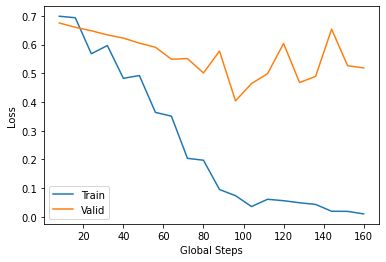

In [18]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== /content/drive/MyDrive/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7890    0.7834    0.7862      2816
           0     0.7878    0.7933    0.7905      2854

    accuracy                         0.7884      5670
   macro avg     0.7884    0.7883    0.7883      5670
weighted avg     0.7884    0.7884    0.7884      5670



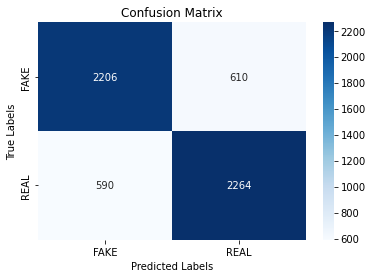

In [19]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)